# Preprocess

In [2]:
import pandas as pd

In [2]:
def read_csv_files(file_paths):
    """
    本函数用于读取所有的CSV文件并存入多个Dataframe中。
    :param file_paths: 一个或多个文件路径 
    :return: 一个或多个Dataframe
    """
    dfs = []
    for i, path in enumerate(file_paths):
        dfs.append(pd.read_csv(path, index_col=0).stack())
    return dfs

In [3]:
def determine_status_sign(status):
    """
    本函数用于处理异常的股票，给股票打上标签，如果成分异常，则打上-1；如果成分正常或者由异常变为正常，则打上1。
    1	ST
    3	PT
    2	撤销ST
    5	*ST
    7	撤消*ST并实行ST
    8	从ST变为*ST
    12	叠加ST
    6	撤销*ST
    9	退市整理期
    4	撤销PT
    13	撤销叠加ST
    14	叠加*ST
    15	撤销叠加*ST
    10	高风险警示
    11	撤销高风险警示
    :param status: 成分异常的表中有一列名为status，根据status的值分别给股票打上标签
    :return: 返回一个具有标签的Dataframe
    """
    if status in [1, 5, 7, 8, 9, 12, 13, 14]:
        return -1
    elif status in [2, 3, 4, 6]:
        return 1
    else:
        return None

In [4]:
def merge_dataframes(list_of_dfs):
    # 使用 concat 方法按列合并 DataFrame
    merged_df = pd.concat(list_of_dfs, axis=1)
    return merged_df

In [5]:
file_paths = [
    '昨收价.csv',  # 昨收价
    '收盘价.csv',  # 收盘价
    '昨开盘.csv',  # 做开盘价
    '开盘价.csv',  # 开盘价
    '涨停价.csv',  # 涨停价
    '涨跌幅.csv'  # 涨跌幅
#     '筛选涨跌幅.csv'
]

df_pre_close, df_close, df_pre_open, df_open, df_stopin, df_ud = read_csv_files(file_paths)

In [6]:
df_st = pd.read_csv('st表.csv', index_col=0)
# 利用-1和1区别status数值，并存在status sign中
df_st['sign'] = df_st['SpecialTradeType'].apply(determine_status_sign)
# 删除inner_id和status，只保留日期day，股票名字id和status sign
df_st = df_st.drop(df_st.columns[[0, 2]], axis=1)
# 将两列打成一行z一列，index为day列，行为id列，数值则是status sign
df_ST_pivot = df_st.pivot(index='SpecialTradeTime', columns='SecuCode', values='sign')
df_ST_pivot.index = pd.to_datetime(df_ST_pivot.index)
df_ST_pivot = df_ST_pivot.resample('D').asfreq()
# 向后传播填写NaN，再把其他的NaN填充为1
df_ST_pivot = df_ST_pivot.ffill().fillna(1)
# 补充日期，从1988.4.28到2023.12.18
date_range = pd.date_range(start='1988-04-28', end='2023-12-29', freq='D')
# 填充日期，如果是全量数据就不需要这个数据
df_ST_pivot = df_ST_pivot.reindex(date_range)
df_ST_pivot = df_ST_pivot.ffill().fillna(1)
df_ST_pivot.index.name = 'day'
df_ST_pivot.rename(columns={'0': 'sign'}, inplace=True)
# 将dataframe变成mutindex，方便之后merge
df_ST_stack = pd.DataFrame(df_ST_pivot.stack())
df_ST_stack.columns = ['sign']
df_ST_stack.index.names = None, None

In [7]:
df = pd.read_csv('昨总股本.csv', index_col=0)
df = df.stack()
df = pd.DataFrame(df)
df.columns = ['pre_number']

In [8]:
df1 = pd.read_csv('购买信息.csv', index_col=0)
df1 = df1.stack()
df1 = pd.DataFrame(df1)
df1.columns = ['tradable']

In [9]:
merge_df = merge_dataframes([df_pre_close, df_close, df_pre_open, df_open, df_stopin, df_ud])
merge_df.columns = ['pre_close', 'close','pre_open', 'open', 'stopin', 'ud']

merge_df = pd.merge(merge_df, df, left_index=True, right_index=True, how='left')
merge_df = pd.merge(merge_df, df1, left_index=True, right_index=True, how='left')

merge_df['pre_close'] = merge_df.pre_close.astype(float).fillna(0)
merge_df['pre_number'] = merge_df.pre_number.astype(float).fillna(0)
merge_df['value'] = merge_df['pre_close'] * merge_df['pre_number']
merge_df = merge_df.fillna(0)

merge_df = pd.merge(merge_df, df_ST_stack, left_index=True, right_index=True, how='left')
merge_df = merge_df.fillna(1)
merge_df.index.names = ['day', 'id']

In [10]:
merge_df

pre_close  close  pre_open   open  stopin      ud  \
day        id                                                             
2000-01-04 000001.SZ      17.45  18.29     17.47  17.50   19.20  4.8138   
           000002.SZ       9.75  10.30      9.70   9.80   10.73  5.6410   
           000003.SZ       5.47   5.74      5.50   5.48    6.02  4.9360   
           000004.SZ       8.51   8.74      8.69   8.55    9.36  2.7027   
           000005.SZ       6.04   6.24      6.08   6.10    6.64  3.3113   
...                         ...    ...       ...    ...     ...     ...   
2023-12-29 688799.SH      47.21  48.94     47.69  47.22   51.93  3.6645   
           688800.SH      39.52  40.18     37.42  39.50   43.47  1.6700   
           688819.SH      27.91  27.92     27.02  28.00   30.70  0.0358   
           688981.SH      53.13  53.02     51.70  53.00   58.44 -0.2070   
           689009.SH      29.20  29.66     28.58  29.25   32.12  1.5753   

                        pre_number  tradable         value  sign  
day        id                                                     
2000-01-04 000001.SZ  1.551847e+09       1.0  2.707973e+10   1.0  
           000002.SZ  5.455375e+08       1.0  5.318990e+09   1.0  
           000003.SZ  3.334336e+08       1.0  1.823882e+09   1.0  
           000004.SZ  8.397668e+07       1.0  7.146416e+08  -1.0  
           000005.SZ  5.180175e+08       1.0  3.128826e+09   1.0  
...                            ...       ...           ...   ...  
2023-12-29 688799.SH  9.380000e+07       1.0  4.428298e+09   1.0  
           688800.SH  1.584199e+08       1.0  6.260753e+09   1.0  
           688819.SH  9.721000e+08       1.0  2.713131e+10   1.0  
           688981.SH  7.946542e+09       1.0  4.221998e+11   1.0  
           689009.SH  0.000000e+00       0.0  0.000000e+00   1.0  

[30987648 rows x 10 columns]

In [140]:
merge_df.to_csv('处理过的全量数据.csv')

# Micro Index Method

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator

In [24]:
merge_df = pd.read_csv('处理过的全量数据.csv', index_col=['day', 'id'])

In [12]:
# dfdf = merge_df[(merge_df['open'] == merge_df['stopin']) & (merge_df['open'] != 0) & (merge_df['value'] < 2500000000)]
# dfdf

In [4]:
def min_400_stock(df):
    """
    本函数用于找到每日市值最低的400只股票，其中要剔除sign为-1的股票以及上市未满7天的股票。
    :param df: 输入Dataframe，这里是merge_df
    :return: 每日市值最低的400只股票组成的Dataframe
    """
    # 创建一个空的 Series
    min_400_stocks_series = pd.Series(dtype=object)

#     筛选出非0市值的数据，同时sign为1.0的数据，并按日期进行分组
    sign_1_nonzero = df[(df['value'] != 0) & (df['sign'] == 1.0) & (df['tradable'] == 1.0)].groupby(level=0)
   
    # 遍历每个日期的数据
    for date, group in sign_1_nonzero:
        # 获取当前日期股票市值最低的400只股票的名字
        min_400 = group.nsmallest(400, 'value').index.get_level_values('id').tolist()
        # 将当前日期的股票数据存储在 Series 中，日期作为索引
        min_400_stocks_series[date] = min_400

    min_400_stocks = pd.DataFrame(min_400_stocks_series)
    min_400_stocks.index = pd.to_datetime(min_400_stocks.index)
    min_400_stocks.sort_index(ascending=True, inplace=True)
    min_400_stocks.index = min_400_stocks.index.strftime('%Y-%m-%d')
    min_400_stocks.columns = ['stock']
    
    return min_400_stocks

In [5]:
min_400_df = min_400_stock(merge_df)

# 测试成分股

In [244]:
df_t = pd.DataFrame(min_400_df.iloc[5813][0])
df_t.columns = ['id']
df_t.to_csv('aa.csv')

In [1]:
merge_df.loc['2015-08-17', '000520.SZ']

NameError: name 'merge_df' is not defined

In [32]:
min_400_df.iloc[4116]

stock    [000803.SZ, 300029.SZ, 300243.SZ, 600768.SH, 3...
Name: 2017-01-04, dtype: object

In [9]:
min_400_df.iloc[3990]

stock    [300268.SZ, 600539.SH, 300372.SZ, 300046.SZ, 3...
Name: 2016-06-30, dtype: object

In [15]:
min_400_df.index.get_loc('2023-12-27')

5813

In [6]:
df_test = min_400_df.explode('stock')

df_test['dum'] = 1
_res = df_test.reset_index().pivot(index='index',columns='stock',values='dum').fillna(0)
_res1 = merge_df.loc[:, 'ud'].unstack()[_res.columns]
matrix1 = _res.values
matrix2 = _res1.values
# matrix2 = np.round(matrix2, decimals=2)

matrix = np.multiply(matrix1, matrix2)
matrix = np.round(matrix, decimals=2)

In [7]:
def draw(df, matrix):
    """
    本函数用于计算指数以及根据计算的指数画图。
    :param df: 输入Dataframe，min_400_stocks
    """
    index = 1000
    df_pic = pd.DataFrame(columns=['day', 'index'])
    # 对于每一个交易日，从中根据市值选出后400的股票并作等权计算
#     for i in range(0, 5816):  # 全量
#     for i in range(3426, 3746):  # 牛市
    for i in range(df.index.get_loc('2000-01-04'), df.index.get_loc('2023-12-29')):  # 熊市
        total_ud = 0  # 涨跌幅
        stock_day = df.index[i]
        total_ud += np.sum(matrix[i])
        if i == df.index.get_loc('2000-01-04'):
            index = index
        else:
#             print(stock_day)
#             print(total_ud)
            index = index * (1 + total_ud / 40000)
#         print(index)
#         print('--------')
        df_pic.loc[len(df_pic)] = [str(stock_day), index]  
    return df_pic

In [8]:
df_pic = draw(min_400_df, matrix)

In [9]:
df_pic

,day,index
0,2000-01-04,1000.000000
1,2000-01-05,1006.340750
2,2000-01-06,1041.147309
3,2000-01-07,1077.532284
4,2000-01-10,1100.927396
...,...,...
5810,2023-12-22,310003.407729
5811,2023-12-25,306173.625630
5812,2023-12-26,302513.243392
5813,2023-12-27,305403.454919


In [23]:
df_pic.to_csv('c.csv')

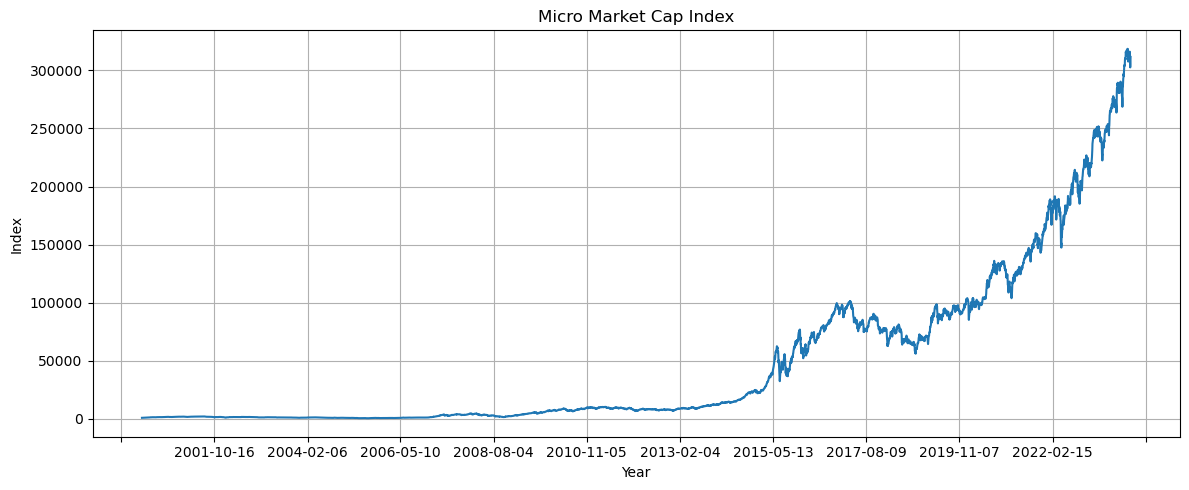

In [16]:

plt.figure(figsize=(12, 5))
plt.plot(df_pic['day'], df_pic['index'], linestyle='-')
# 设置间隔为一个月
months = MonthLocator(interval=18)
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Micro Market Cap Index')
plt.xlabel('Year')
plt.ylabel('Index')
plt.grid(True)
plt.tight_layout()

plt.show()

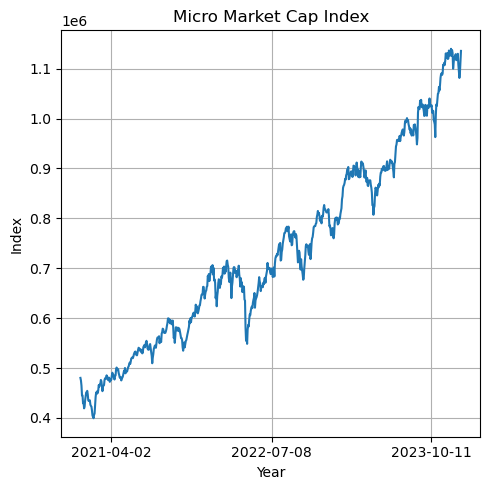

In [32]:
filtered_data = df_pic[(df_pic['day'] < '2024-01-01') & (df_pic['day'] > '2021-01-01')]

plt.figure(figsize=(5, 5))
plt.plot(filtered_data['day'], filtered_data['index'], linestyle='-')
# 设置间隔为一个月
months = MonthLocator(interval=10)
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Micro Market Cap Index')
plt.xlabel('Year')
plt.ylabel('Index')
plt.grid(True)
plt.tight_layout()

plt.show()

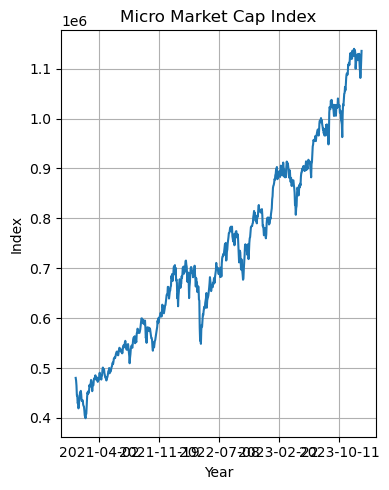

In [41]:
plt.figure(figsize=(4, 5))
plt.plot(filtered_data['day'], filtered_data['index'], linestyle='-')
# 设置间隔为一个月
months = MonthLocator(interval=5) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Micro Market Cap Index')
plt.xlabel('Year')
plt.ylabel('Index')
plt.grid(True)
plt.tight_layout()

plt.show()

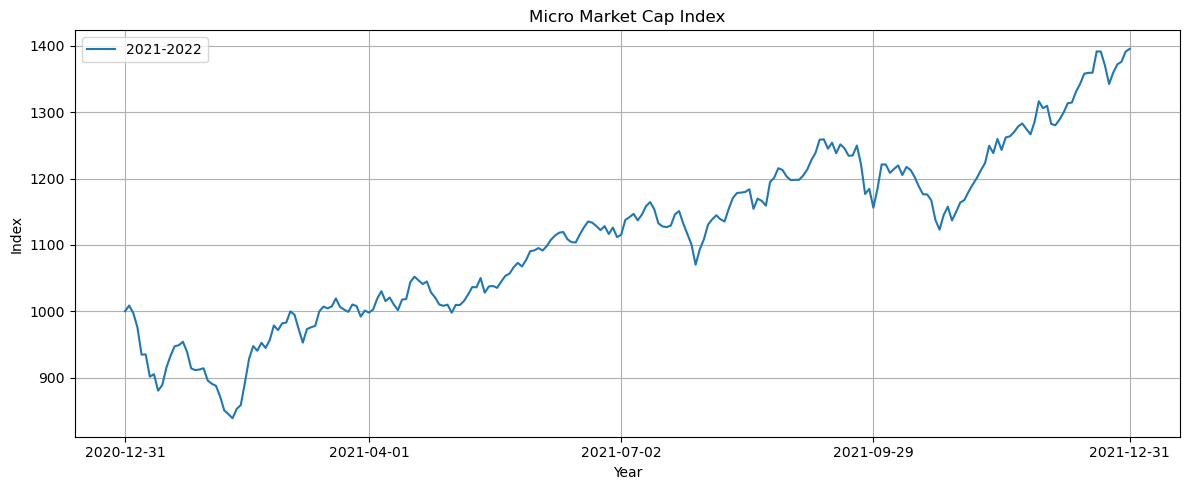

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(df_pic['day'], df_pic['index'], linestyle='-', label='2021-2022')
# 设置间隔为一个月
months = MonthLocator(interval=2) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Micro Market Cap Index')
plt.xlabel('Year')
plt.ylabel('Index')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

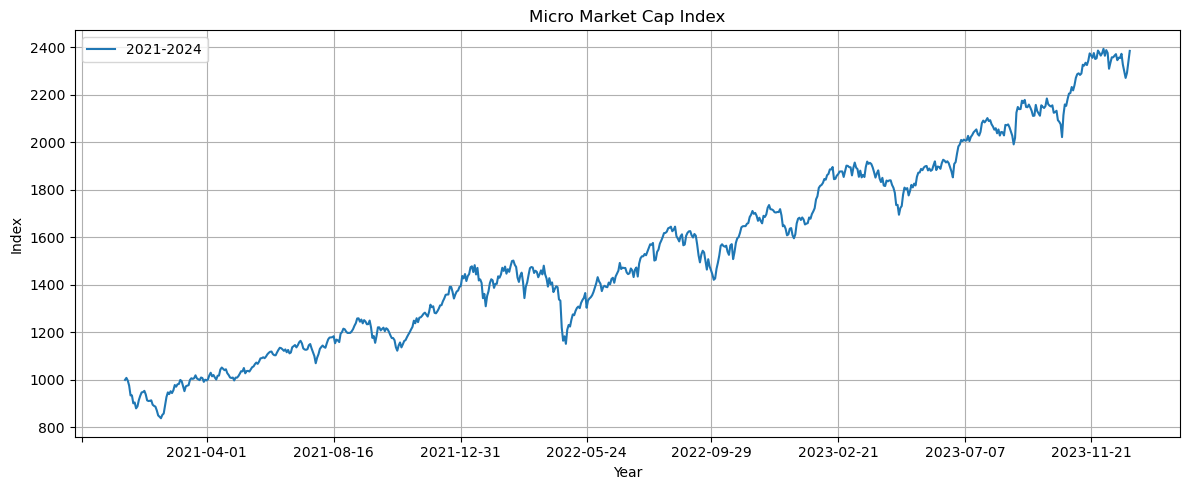

In [68]:
plt.figure(figsize=(12, 5))
plt.plot(df_pic['day'], df_pic['index'], linestyle='-', label='2021-2024')
# 设置间隔为一个月
months = MonthLocator(interval=3) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Micro Market Cap Index')
plt.xlabel('Year')
plt.ylabel('Index')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

In [17]:
df_test = df_pic.copy()

In [18]:
# 假设你的DataFrame叫做df
reference_price = df_test[df_test['day'] == '2000-01-04']['index'].values[0]

# 计算涨跌幅
df_test['total_ud'] = (df_test['index'] - reference_price) / reference_price * 100

# Test

In [19]:
df_test

,day,index,total_ud
0,2000-01-04,1000.000000,0.000000
1,2000-01-05,1006.340750,0.634075
2,2000-01-06,1041.147309,4.114731
3,2000-01-07,1077.532284,7.753228
4,2000-01-10,1100.927396,10.092740
...,...,...,...
5810,2023-12-22,310003.407729,30900.340773
5811,2023-12-25,306173.625630,30517.362563
5812,2023-12-26,302513.243392,30151.324339
5813,2023-12-27,305403.454919,30440.345492


# 不加筛选涨跌幅.csv

In [97]:
df_test

,day,index,total_ud
0,2020-12-31,1000.000000,0.000000
1,2021-01-04,1008.526500,0.852650
2,2021-01-05,997.838388,-0.216161
3,2021-01-06,976.790484,-2.320952
4,2021-01-07,935.754051,-6.424595
...,...,...,...
723,2023-12-25,2480.679309,148.067931
724,2023-12-26,2451.022167,145.102217
725,2023-12-27,2474.439233,147.443923
726,2023-12-28,2524.026995,152.402700


# 牛市

In [38]:
df_test

,day,index,total_ud
0,2014-03-12,1000.000000,0.000000
1,2014-03-13,1010.715750,1.071575
2,2014-03-14,1011.331023,1.133102
3,2014-03-17,1032.607405,3.260741
4,2014-03-18,1038.945808,3.894581
...,...,...,...
315,2015-06-24,4224.476413,322.447641
316,2015-06-25,4091.452932,309.145293
317,2015-06-26,3788.481865,278.848186
318,2015-06-29,3514.053710,251.405371


# 熊市

In [202]:
df_test

,day,index,total_ud
0,2015-06-01,1000.000000,0.000000
1,2015-06-02,1042.638500,4.263850
2,2015-06-03,1055.631861,5.563186
3,2015-06-04,1049.873125,4.987313
4,2015-06-05,1068.179500,6.817950
...,...,...,...
261,2016-06-24,1329.644533,32.964453
262,2016-06-27,1359.860040,35.986004
263,2016-06-28,1375.823437,37.582344
264,2016-06-29,1380.946659,38.094666


# 2021-2024年度 加筛选涨跌幅.csv

In [82]:
df_test

,day,index,total_ud
0,2020-12-31,1000.000000,0.000000
1,2021-01-04,1008.526500,0.852650
2,2021-01-05,997.267310,-0.273269
3,2021-01-06,975.665752,-2.433425
4,2021-01-07,934.676571,-6.532343
...,...,...,...
723,2023-12-25,2298.168171,129.816817
724,2023-12-26,2270.692996,127.069300
725,2023-12-27,2292.387197,129.238720
726,2023-12-28,2338.326636,133.832664


In [55]:
df_300 = pd.read_excel('沪深300-2021-2024.xlsx')
df_300 = df_300.iloc[:,[0,6,8]]
df_300.columns = ['day', 'day_ud', 'total_ud']
df_300 = df_300.sort_values('day')
df_300.iloc[0, 1:3] = 0
df_300.set_index('day', inplace=True)

In [157]:
df_300_cow = pd.read_excel('沪深300牛市.xlsx')
df_300_cow = df_300_cow.iloc[:,[0,6,8]]
df_300_cow.columns = ['day', 'day_ud', 'total_ud']
df_300_cow = df_300_cow.sort_values('day')
df_300_cow.iloc[0, 1:3] = 0
df_300_cow.set_index('day', inplace=True)

In [191]:
df_300_rbs = pd.read_excel('沪深300熊市.xlsx')
df_300_rbs = df_300_rbs.iloc[:,[0,6,8]]
df_300_rbs.columns = ['day', 'day_ud', 'total_ud']
df_300_rbs = df_300_rbs.sort_values('day')
df_300_rbs.iloc[0, 1:3] = 0
df_300_rbs.set_index('day', inplace=True)

In [ ]:
df_300_2017_2018 = pd.read_excel('000300.SH-2017-2018.xlsx')
df_300_2017_2018 = df_300_2017_2018.iloc[:,[0,6,8]]
df_300_2017_2018.columns = ['day', 'day_ud', 'total_ud']
df_300_2017_2018 = df_300_2017_2018.sort_values('day')
df_300_2017_2018.iloc[0, 1:3] = 0
df_300_2017_2018.set_index('day', inplace=True)

In [192]:
df_300_rbs

,day_ud,total_ud
day,,
2015-06-01,0.00,0.00
2015-06-02,1.69,6.63
2015-06-03,-0.35,6.25
2015-06-04,0.74,7.04
2015-06-05,0.95,8.05
...,...,...
2016-06-24,-1.29,-36.43
2016-06-27,1.41,-35.54
2016-06-28,0.51,-35.21


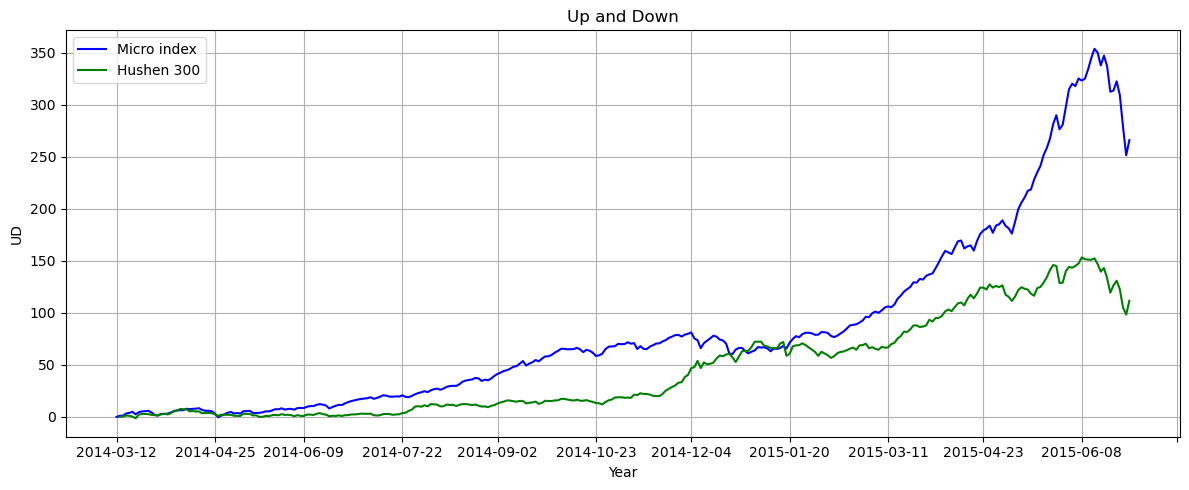

In [162]:
plt.figure(figsize=(12, 5))
plt.plot(df_test['day'], df_test['total_ud'], linestyle='-', color='blue', label='Micro index')

plt.plot(df_300_cow.index, df_300_cow['total_ud'], linestyle='-', color='green', label='Hushen 300')

# 设置间隔为一个月
months = MonthLocator(interval=1) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Up and Down')
plt.xlabel('Year')
plt.ylabel('UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

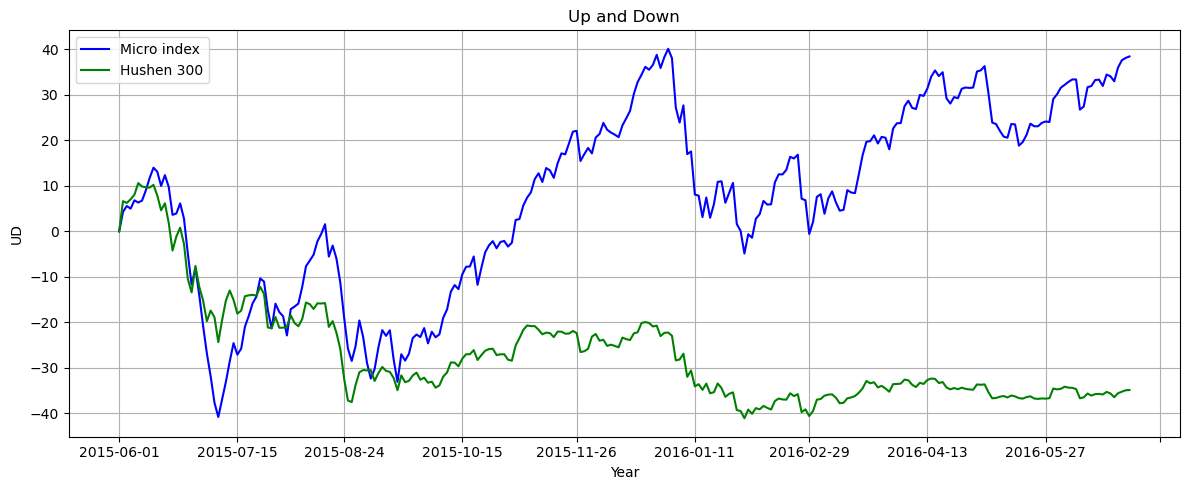

In [203]:
plt.figure(figsize=(12, 5))
plt.plot(df_test['day'], df_test['total_ud'], linestyle='-', color='blue', label='Micro index')
plt.plot(df_300_rbs.index, df_300_rbs['total_ud'], linestyle='-', color='green', label='Hushen 300')

# 设置间隔为一个月
months = MonthLocator(interval=1) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Up and Down')
plt.xlabel('Year')
plt.ylabel('UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

In [217]:
df_test['day_ud'] = df_test['index'].pct_change()
df_test['day_ud'] = df_test['day_ud'] * 100
df_test = df_test.fillna(0).set_index('day')
df_test.index.name = None

In [218]:
df_test

,index,total_ud,day_ud
2023-06-29,1000.000000,0.000000,0.000000
2023-06-30,1015.708750,1.570875,1.570875
2023-07-03,1019.820339,1.982034,0.404800
2023-07-04,1029.607045,2.960704,0.959650
2023-07-05,1027.144225,2.714422,-0.239200
...,...,...,...
2023-12-22,1204.812804,20.481280,-1.910900
2023-12-25,1189.928547,18.992855,-1.235400
2023-12-26,1175.702654,17.570265,-1.195525
2023-12-27,1186.935317,18.693532,0.955400


In [229]:
merge = pd.merge(df_test, min_400_df, left_index=True, right_index=True, how='left')


In [230]:
merge

,index,total_ud,day_ud,stock
2023-06-29,1000.000000,0.000000,0.000000,"[688701.SH, 300478.SZ, 002856.SZ, 688565.SH, 3..."
2023-06-30,1015.708750,1.570875,1.570875,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 3..."
2023-07-03,1019.820339,1.982034,0.404800,"[688701.SH, 300478.SZ, 301156.SZ, 688565.SH, 0..."
2023-07-04,1029.607045,2.960704,0.959650,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 0..."
2023-07-05,1027.144225,2.714422,-0.239200,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 0..."
...,...,...,...,...
2023-12-22,1204.812804,20.481280,-1.910900,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6..."
2023-12-25,1189.928547,18.992855,-1.235400,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6..."
2023-12-26,1175.702654,17.570265,-1.195525,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6..."
2023-12-27,1186.935317,18.693532,0.955400,"[688701.SH, 688565.SH, 688215.SH, 688096.SH, 6..."


In [231]:
merge_df.loc['2022-12-29', '688701.SH']

pre_close     8.330000e+00
close         8.220000e+00
pre_open      8.560000e+00
open          8.350000e+00
stopin        9.160000e+00
ud           -1.320500e+00
pre_number    1.342774e+08
tradable      1.000000e+00
value         1.118531e+09
sign          1.000000e+00
Name: (2022-12-29, 688701.SH), dtype: float64

In [234]:
# # 创建money列并设置第一行的值
merge['money'] = 0.0
merge['money_real'] = 0.0
merge.at[merge.index[0], 'money_real'] = 400000000
# merge.at[merge.index[0], 'money'] = 400000000

# 计算money列从第二行开始的值
for i in range(0, len(merge)):
    if i == 0:
        buy_stock = set(merge.at[merge.index[i + 1], 'stock'])  # 第一天进入，根据收盘价筛选购买400只股票
        money = merge.loc[merge.index[i], 'money_real']
        fee = money * 0.001
        merge.at[merge.index[i + 1], 'money_real'] = money - fee  # 记录下一天手上的实际资金
#         merge.at[merge.index[i + 1], 'money'] = money 
# for i in range(1, 6):
    elif i > 0 and i < len(merge)-1:
        fee = 0
        total_ud = 0
        total_ud1 = 0
        pre_assets = merge.loc[merge.index[i], 'money_real'] / 400  # 算上涨跌幅并扣除调仓费用后，等权每只股票分到的金额
        # 计算不同的股票数量
        today_stock = set(merge.at[merge.index[i], 'stock'])  # 今日成分股
        tomorrow_stock = set(merge.at[merge.index[i + 1], 'stock'])  # 明日成分股
        today_delete = today_stock - tomorrow_stock  # 今日成分股剔除的股票
        tomorrow_add = tomorrow_stock - today_stock  # 明日成分股加入的股票
        different_stocks_number = len(today_stock.symmetric_difference(tomorrow_stock)) / 2  # 不同股票的数量
    #     print(previous_stock)
        for stock in today_stock:
            # 锁定日期：print(merge.index[i])，锁定股票：print(stock)
            # 两种算法计算涨跌幅，一个是利用每只股票的涨跌幅和求涨跌幅
            # ud = merge_df.loc[merge.index[i], stock][5] / 100
            # total_ud1 += ud / 400  # 取涨跌幅所占的权重，400只股票也就是除以400
            # 第二个是利用指数的涨跌幅直接拿到作为收益的涨跌幅
            total_ud = merge.loc[merge.index[i], 'day_ud'] / 100
        for stock in today_stock:
            ud = merge_df.loc[merge.index[i], stock][5] / 100
            if stock in today_delete:
                fee += pre_assets * (1 + ud) * 0.001  # 如果是剔除的股票，则计算卖出手续费
            else:
                # 昨日每只股票到今天的最终价格减去今天的等权金额
                # 如果是正数，说明说赚钱了应该减仓；如果是负数，说明亏钱了，应该加仓
                assets = pre_assets * (1 + total_ud)
                number = pre_assets * (1 + ud) - assets
#                 print(number)
                if number > 0:
                    fee += number * 0.002  # 涨的股票应该卖出
                elif number < 0:
                    fee += abs(number * 0.001)  # 跌的股票应该买入

        # 计算手续费
        fee += different_stocks_number * 0.001 * assets  # 加入的成分股买入手续费
        # 参考每日涨跌幅计算money
        #             ud_per_day = merge.at[merge.index[i], 'day_ud'] / 100
        #             previous_money = merge.at[merge.index[i - 1], 'money']
        merge.at[merge.index[i + 1], 'money_real'] = pre_assets * 400 * (1 + total_ud) - fee
#         merge.at[merge.index[i + 1], 'money'] = pre_assets * 400 * (1 + total_ud)

    elif i == len(merge) -1:
        money = merge.loc[merge.index[i], 'money_real']
        today_stock = set(merge.at[merge.index[i], 'stock'])  # 今日成分股
        total_ud = merge.loc[merge.index[i], 'day_ud'] / 100
        fee = money * (1 + total_ud) * 0.002
        final_money = money * (1 + total_ud) - fee
        merge.at[merge.index[i], 'money_real'] = pre_assets * 400 * (1 + total_ud) - fee    
#         merge.at[merge.index[i], 'money'] = pre_assets * 400 * (1 + total_ud)   

In [235]:
merge

,index,total_ud,day_ud,stock,money,money_real
2023-06-29,1000.000000,0.000000,0.000000,"[688701.SH, 300478.SZ, 002856.SZ, 688565.SH, 3...",0.0,4.000000e+08
2023-06-30,1015.708750,1.570875,1.570875,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 3...",0.0,3.996000e+08
2023-07-03,1019.820339,1.982034,0.404800,"[688701.SH, 300478.SZ, 301156.SZ, 688565.SH, 0...",0.0,4.058543e+08
2023-07-04,1029.607045,2.960704,0.959650,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 0...",0.0,4.074742e+08
2023-07-05,1027.144225,2.714422,-0.239200,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 0...",0.0,4.113600e+08
...,...,...,...,...,...,...
2023-12-22,1204.812804,20.481280,-1.910900,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",0.0,4.867098e+08
2023-12-25,1189.928547,18.992855,-1.235400,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",0.0,4.773674e+08
2023-12-26,1175.702654,17.570265,-1.195525,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",0.0,4.714178e+08
2023-12-27,1186.935317,18.693532,0.955400,"[688701.SH, 688565.SH, 688215.SH, 688096.SH, 6...",0.0,4.657427e+08


In [ ]:
merge['money'] = 0.0
merge.at[merge.index[0], 'money'] = 400000000

# 计算money列从第二行开始的值
for i in range(1, len(merge)):
    fee = 0
    total_ud = 0
    rebalence_ud = 0
    pre_assets = merge.loc[merge.index[i - 1], 'money'] / 400  # 昨日等权每只股票分到的金额
    # 计算不同的股票数量
    previous_stock = set(merge.at[merge.index[i - 1], 'stock'])  # 昨日成分股
    current_stock = set(merge.at[merge.index[i], 'stock'])  # 今日成分股
    previous_delete = previous_stock - current_stock  # 昨日有的股票，也就是今日成分股剔除的股票
    current_delete = current_stock - previous_stock  # 今日有的股票，也就是今日成分股加入的股票
    different_stocks_number = len(current_stock.symmetric_difference(previous_stock)) / 2  # 不同股票的数量
    for stock in previous_stock:
        # 锁定日期：print(merge.index[i])，锁定股票：print(stock)
        pre_open = self.df.loc[merge.index[i], stock][2]  # 昨日开盘价
        today_open = self.df.loc[merge.index[i], stock][3]  # 今日开盘价
        pre_close =  self.df.loc[merge.index[i], stock][0]  # 今日开盘价
        ud = (today_open - pre_open) / pre_open  # 计算昨天购买时到今天卖出时总共的涨跌幅
        ud2 = (pre_close - pre_open) / pre_open  # 开盘买，收盘做rebalance，计算一天的涨跌幅
        total_ud += ud / 400
        rebalence_ud += ud2 / 400
    for stock in previous_stock:
        pre_open = self.df.loc[merge.index[i], stock][2]  # 昨日开盘价
        today_open = self.df.loc[merge.index[i], stock][3]  # 今日开盘价
        pre_close =  self.df.loc[merge.index[i], stock][0]  # 今日开盘价
        ud = (today_open - pre_open) / pre_open  # 计算昨天购买时到今天卖出时总共的涨跌幅
        assets = pre_assets * (1 + rebalence_ud)
        if stock in previous_delete:
            fee += pre_assets * (1 + ud) * 0.002  # 如果是剔除的股票，则计算卖出手续费
        else:
            # 昨日每只股票到今天的最终价格减去今天的等权金额
            # 如果是正数，说明说赚钱了应该减仓；如果是负数，说明亏钱了，应该加仓
            number = pre_assets * (1 + ud) - assets
            if number > 0:
                fee += number * 0.002  # 涨的股票应该卖出
            elif number < 0:
                fee += abs(number * 0.001)  # 跌的股票应该买入

    # 计算手续费
    fee += different_stocks_number * 0.001 * assets  # 加入的成分股买入手续费

    # 通过总共的资金减去调仓以及剔除加入成分股的手续费
    merge.at[merge.index[i], 'money'] = pre_assets * 400 * (1 + total_ud) - fee  # 开盘调仓完扣除手续费剩余的钱，今日手上拿的钱

In [183]:
merge

,index,total_ud,day_ud,stock,money,total_income_ud,day_income_ud
2022-12-29,1000.000000,0.000000,0.000000,"[688701.SH, 688004.SH, 300478.SZ, 603729.SH, 6...",4.000000e+08,0.000000,0.000000
2022-12-30,1010.457000,1.045700,1.045700,"[688701.SH, 688004.SH, 300478.SZ, 688215.SH, 6...",3.996000e+08,1.039594,1.039594
2023-01-03,1039.301000,3.930100,2.854550,"[688701.SH, 688004.SH, 300478.SZ, 688081.SH, 6...",4.037542e+08,3.917208,2.848006
2023-01-04,1051.973717,5.197372,1.219350,"[688701.SH, 300478.SZ, 688004.SH, 603709.SH, 6...",4.152532e+08,5.177462,1.212748
2023-01-05,1054.554209,5.455421,0.245300,"[688701.SH, 300478.SZ, 688004.SH, 600768.SH, 6...",4.202891e+08,5.430160,0.240259
...,...,...,...,...,...,...,...
2023-12-22,1484.949176,48.494918,-1.910900,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",5.950577e+08,46.054947,-1.919495
2023-12-25,1466.604114,46.660411,-1.235400,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",5.836356e+08,44.234617,-1.246332
2023-12-26,1449.070495,44.907049,-1.195525,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",5.763615e+08,42.498255,-1.203845
2023-12-27,1462.914914,46.291491,0.955400,"[688701.SH, 688565.SH, 688215.SH, 688096.SH, 6...",5.694230e+08,43.847020,0.946513


In [236]:
# 假设你的DataFrame叫做df
# reference_price = merge[merge.index == '2023-06-29']['money'].values[0]
reference_price1 = merge[merge.index == '2023-06-29']['money_real'].values[0]

# 计算涨跌幅
# merge['total_income_ud'] = (merge['money'] - reference_price) / reference_price * 100
merge['total_income_ud_real'] = (merge['money_real'] - reference_price1) / reference_price1 * 100

In [241]:
merge['day_income_ud'] = merge['money_real'].pct_change()
merge['day_income_ud'] = merge['day_income_ud'] * 100
merge = merge.fillna(0)
merge.index.name = None

In [242]:
merge

,index,total_ud,day_ud,stock,money,money_real,total_income_ud_real,day_income_ud
2023-06-29,1000.000000,0.000000,0.000000,"[688701.SH, 300478.SZ, 002856.SZ, 688565.SH, 3...",0.0,4.000000e+08,0.000000,0.000000
2023-06-30,1015.708750,1.570875,1.570875,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 3...",0.0,3.996000e+08,-0.100000,-0.100000
2023-07-03,1019.820339,1.982034,0.404800,"[688701.SH, 300478.SZ, 301156.SZ, 688565.SH, 0...",0.0,4.058543e+08,1.463568,1.565133
2023-07-04,1029.607045,2.960704,0.959650,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 0...",0.0,4.074742e+08,1.868548,0.399138
2023-07-05,1027.144225,2.714422,-0.239200,"[688701.SH, 300478.SZ, 688565.SH, 002856.SZ, 0...",0.0,4.113600e+08,2.839988,0.953621
...,...,...,...,...,...,...,...,...
2023-12-22,1204.812804,20.481280,-1.910900,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",0.0,4.867098e+08,21.677445,0.750029
2023-12-25,1189.928547,18.992855,-1.235400,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",0.0,4.773674e+08,19.341853,-1.919495
2023-12-26,1175.702654,17.570265,-1.195525,"[688701.SH, 688565.SH, 688096.SH, 688215.SH, 6...",0.0,4.714178e+08,17.854457,-1.246332
2023-12-27,1186.935317,18.693532,0.955400,"[688701.SH, 688565.SH, 688215.SH, 688096.SH, 6...",0.0,4.657427e+08,16.435671,-1.203845


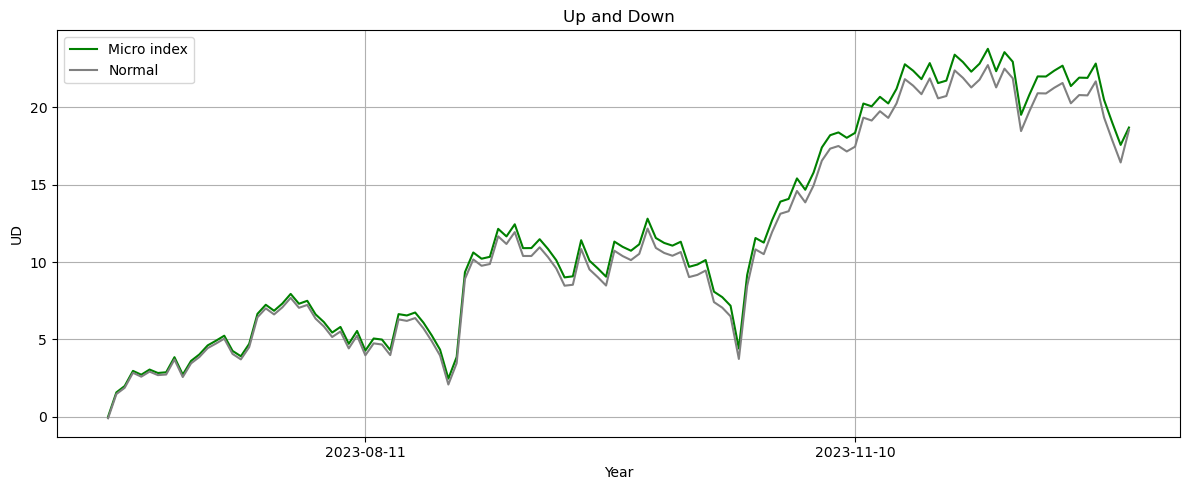

In [227]:
plt.figure(figsize=(12, 5))
plt.plot(merge.index, merge['total_ud'], linestyle='-', color='green', label='Micro index')
plt.plot(merge.index, merge['total_income_ud_real'], linestyle='-', color='grey', label='Normal')
# plt.plot(df_300_rbs.index, df_300_rbs['total_ud'], linestyle='-', color='green', label='Hushen 300')

# 设置间隔为一个月
months = MonthLocator(interval=2) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Up and Down')
plt.xlabel('Year')
plt.ylabel('UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

In [152]:
(merge['day_ud']).sum()

39.60859999999983

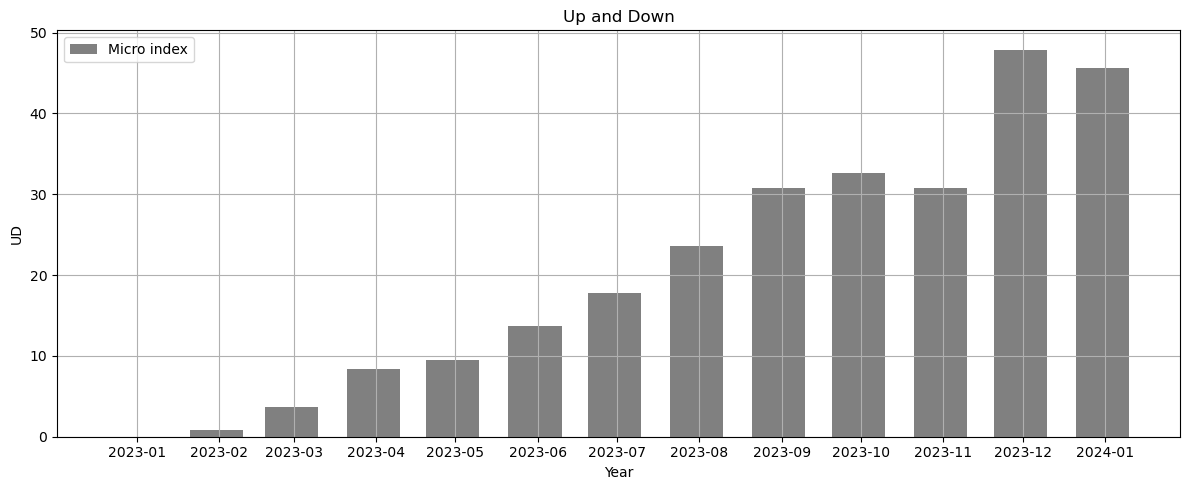

In [153]:
merge.index = pd.to_datetime(merge.index)

monthly_ud = merge['total_ud'].resample('M').sum()
monthly_income = merge['total_income_ud'].resample('M').sum()


plt.figure(figsize=(12, 5))
plt.bar(monthly_income.index, monthly_ud - monthly_income , linestyle='-', color='grey', label='Micro index', width=20)
# plt.plot(merge.index, , linestyle='-', color='grey', label='Normal')
# plt.plot(df_300_rbs.index, df_300_rbs['total_ud'], linestyle='-', color='green', label='Hushen 300')

# 设置间隔为一个月
months = MonthLocator(interval=1) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Up and Down')
plt.xlabel('Year')
plt.ylabel('UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(merge.index, merge['total_ud'], linestyle='-', color='blue', label='Micro index')
plt.plot(merge.index, merge['total_income_ud'], linestyle='-', color='grey', label='Normal')
# plt.plot(df_300_rbs.index, df_300_rbs['total_ud'], linestyle='-', color='green', label='Hushen 300')

# 设置间隔为一个月
months = MonthLocator(interval=2) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Up and Down')
plt.xlabel('Year')
plt.ylabel('UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

# 牛市（2014.3.12-2015.6.30）日微盘股累计涨跌幅和沪深300对比

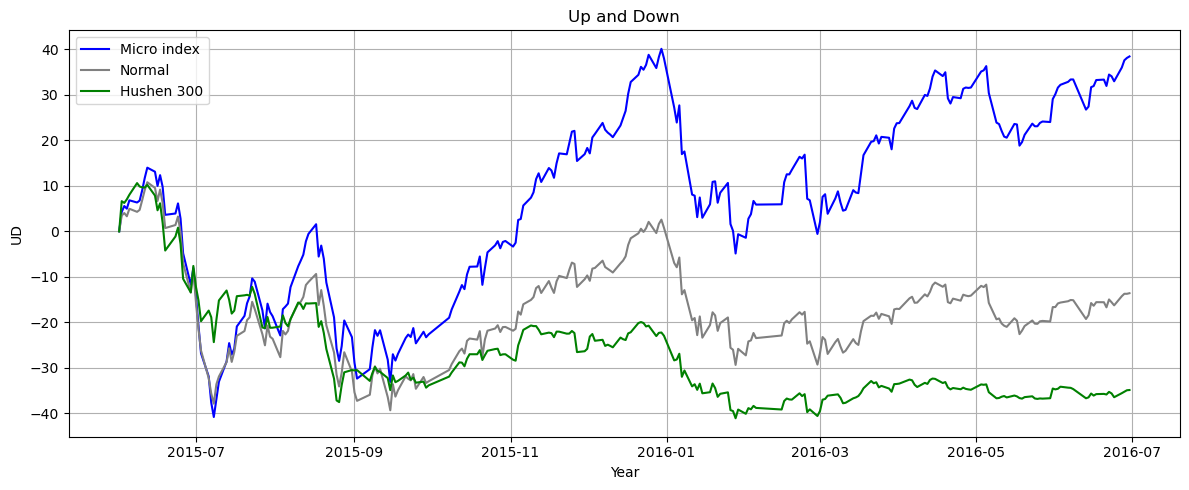

In [225]:
plt.figure(figsize=(12, 5))
plt.plot(merge.index, merge['total_ud'], linestyle='-', color='blue', label='Micro index')
plt.plot(merge.index, merge['total_income_ud'], linestyle='-', color='grey', label='Normal')
plt.plot(df_300_rbs.index, df_300_rbs['total_ud'], linestyle='-', color='green', label='Hushen 300')

# 设置间隔为一个月
months = MonthLocator(interval=2) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Up and Down')
plt.xlabel('Year')
plt.ylabel('UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

# 2021-2024累计涨跌幅曲线对比

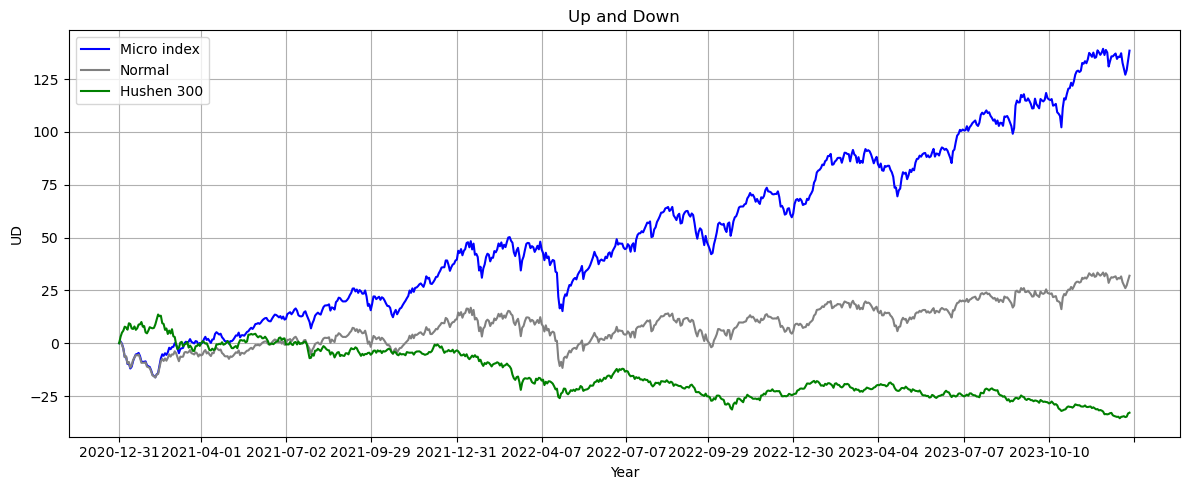

In [125]:
plt.figure(figsize=(12, 5))
plt.plot(df_test.index, df_test['total_ud'], linestyle='-', color='blue', label='Micro index')
plt.plot(merge.index, merge['total_income_ud'], linestyle='-', color='grey', label='Normal')
plt.plot(df_300.index, df_300['total_ud'], linestyle='-', color='green', label='Hushen 300')

# 设置间隔为一个月
months = MonthLocator(interval=2) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Up and Down')
plt.xlabel('Year')
plt.ylabel('UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

# 2021-2024月度超额 
### 考虑市场因素的微盘股指数 vs 沪深300

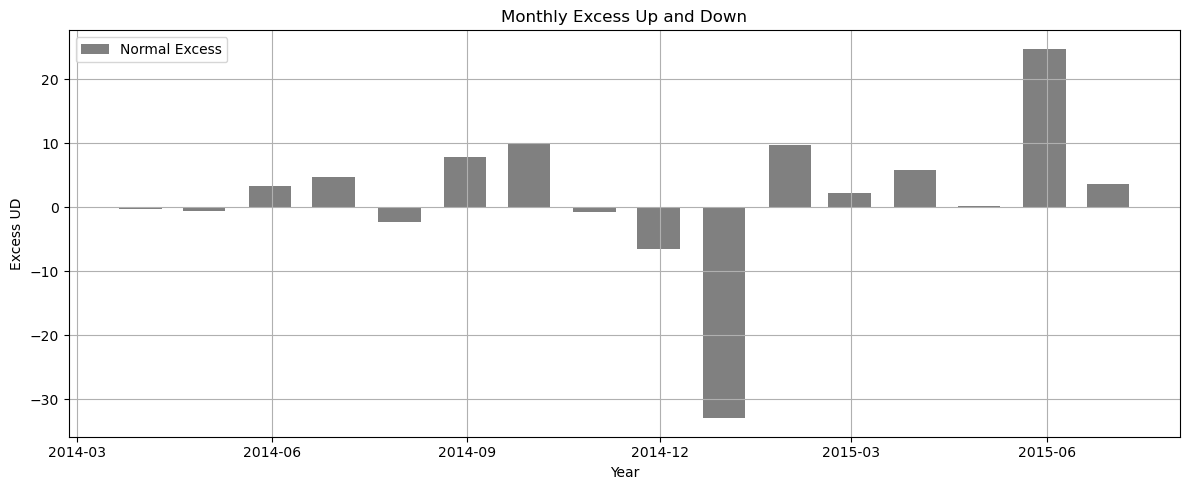

In [175]:
df_300_cow.index = pd.to_datetime(df_300_cow.index)
df_test.index = pd.to_datetime(df_test.index)
merge.index = pd.to_datetime(merge.index)

# 将每日涨跌幅按照月份进行累积求和
monthly_ud = df_test['day_ud'].resample('M').sum()
monthly_income = merge['day_income_ud'].resample('M').sum()
monthly_ud_300 = df_300_cow['day_ud'].resample('M').sum()

# 绘制图表
plt.figure(figsize=(12, 5))
# plt.plot(monthly_ud.index, monthly_ud, linestyle='-', color='blue', label='Micro index Excess')
# plt.bar(monthly_income.index, monthly_income, linestyle='-', color='grey', label='Normal Excess')
# plt.bar(monthly_ud_300.index, monthly_ud_300, linestyle='-', color='green', label='Hushen 300 Excess')
plt.bar(monthly_income.index, monthly_income - monthly_ud_300, color='grey', label='Normal Excess', width=20)

# 设置间隔为一个月
months = MonthLocator(interval=3) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Monthly Excess Up and Down')
plt.xlabel('Year')
plt.ylabel('Excess UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

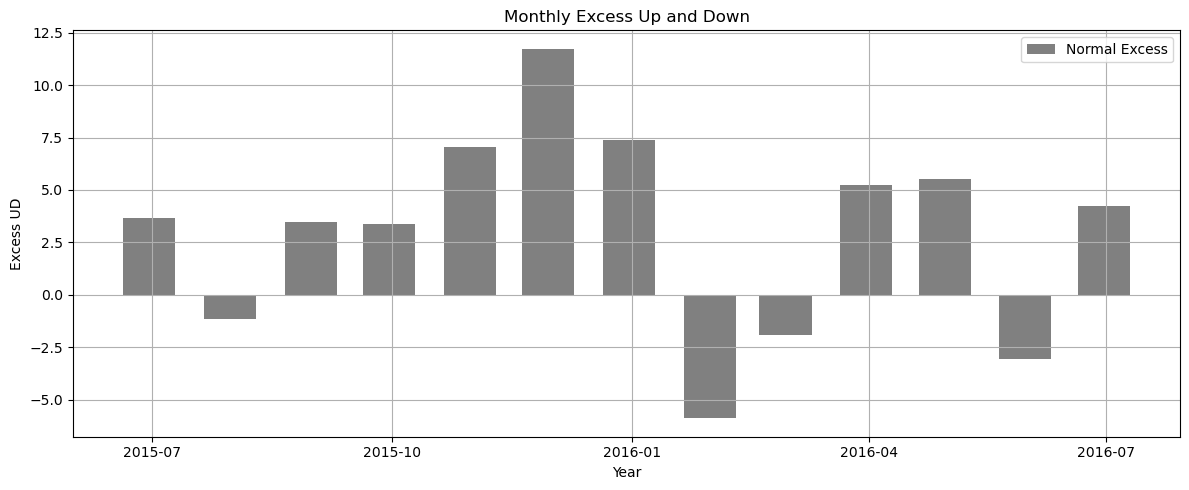

In [216]:
df_300_rbs.index = pd.to_datetime(df_300_rbs.index)
df_test.index = pd.to_datetime(df_test.index)
merge.index = pd.to_datetime(merge.index)

# 将每日涨跌幅按照月份进行累积求和
monthly_ud = df_test['day_ud'].resample('M').sum()
monthly_income = merge['day_income_ud'].resample('M').sum()
monthly_ud_300 = df_300_rbs['day_ud'].resample('M').sum()

# 绘制图表
plt.figure(figsize=(12, 5))
# plt.plot(monthly_ud.index, monthly_ud, linestyle='-', color='blue', label='Micro index Excess')
# plt.bar(monthly_income.index, monthly_income, linestyle='-', color='grey', label='Normal Excess')
# plt.bar(monthly_ud_300.index, monthly_ud_300, linestyle='-', color='green', label='Hushen 300 Excess')
plt.bar(monthly_income.index, monthly_income - monthly_ud_300, color='grey', label='Normal Excess', width=20)

# 设置间隔为一个月
months = MonthLocator(interval=3) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

plt.title('Monthly Excess Up and Down')
plt.xlabel('Year')
plt.ylabel('Excess UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()

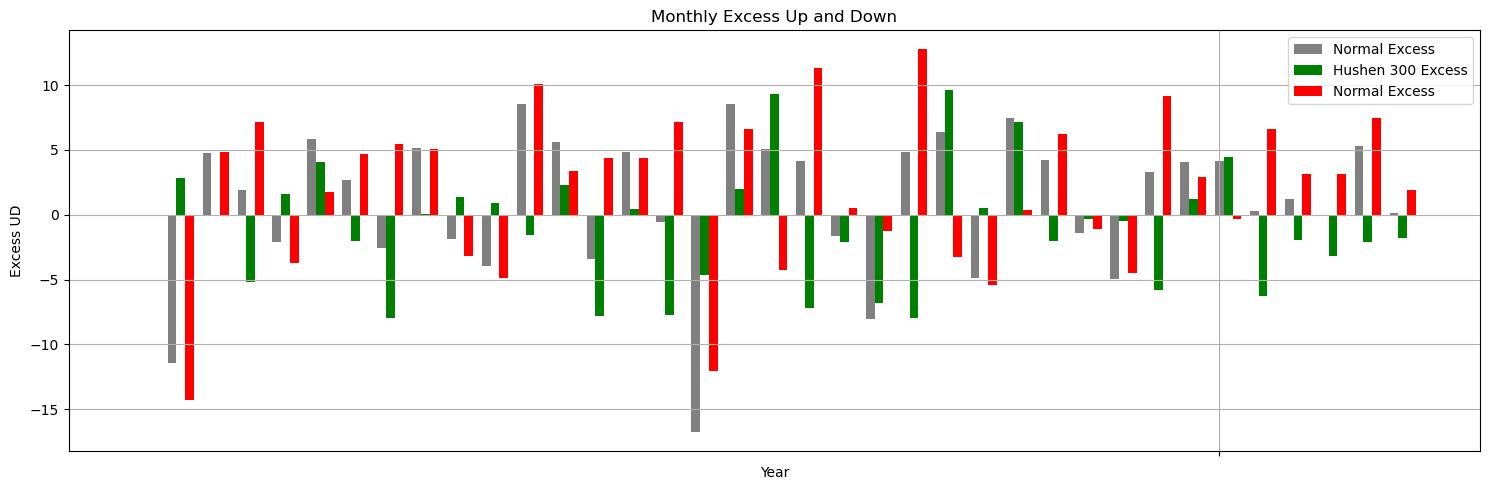

In [168]:
import numpy as np

# 生成 x 轴位置
x = np.arange(len(monthly_income.index))

# 设置柱状图的宽度
bar_width = 0.25

plt.figure(figsize=(15, 5))

# 第一个柱状图（monthly_income）
plt.bar(x, monthly_income, width=bar_width, color='grey', label='Normal Excess')

# 第二个柱状图（monthly_ud_300），往右偏移 bar_width
plt.bar(x + bar_width, monthly_ud_300, width=bar_width, color='green', label='Hushen 300 Excess')

# 第三个柱状图（monthly_income - monthly_ud_300），再往右偏移 bar_width
plt.bar(x + 2 * bar_width, monthly_income - monthly_ud_300, width=bar_width, color='red', label='Normal Excess')

# 设置 x 轴刻度标签
plt.xticks(x + bar_width, monthly_income.index)


# 设置间隔为一个月
months = MonthLocator(interval=3) 
# 应用间隔到 x 轴
plt.gca().xaxis.set_major_locator(months)

# 其他设置...
plt.title('Monthly Excess Up and Down')
plt.xlabel('Year')
plt.ylabel('Excess UD')
plt.grid(True)
plt.tight_layout()
plt.legend()

plt.show()


In [ ]:
# 创建money列并设置第一行的值
merge['money'] = 0.0
idx = 4
# merge.at[merge.index[0], 'money'] = 400000000
for i in range(0, len(merge)):
#     print('-----1-----')
    if i == 0:
        fee = 0
        merge.at[merge.index[i], 'money'] = 400000000
        pre_assets = merge.at[merge.index[i], 'money'] / 400
        for i in range(i, 4):
            money = merge.at[merge.index[i], 'money']
            ud = merge.loc[merge.index[i + 1], 'day_ud'] / 100
            merge.at[merge.index[i + 1], 'money'] = money * (1 + ud)
#             print(merge.index[i])
#             print(merge.at[merge.index[i], 'money'])
#             print('-----2-----')
        assets = merge.at[merge.index[idx], 'money'] / 400
        today_stock = set(merge.at[merge.index[idx], 'stock'])  # 今日成分股
        tomorrow_stock = set(merge.at[merge.index[idx + 1], 'stock'])  # 明日成分股
        today_delete = today_stock - tomorrow_stock
        different_stocks_number = len(today_stock.symmetric_difference(tomorrow_stock)) / 2  # 不同股票的数量
        for stock in today_stock:
            close = merge_df.loc[merge.index[0], stock][1]
            ud = (merge_df.loc[merge.index[idx], stock][1] - close) / close
            if stock in today_delete:
                fee += pre_assets * (1 + ud) * 0.002
            else:
                number = pre_assets * (1 + ud) - assets
                if number > 0:
                    fee += number * 0.002  # 涨的股票应该卖出
                elif number < 0:
                    fee += abs(number * 0.001)  # 跌的股票应该买入
        fee += different_stocks_number * 0.001 * assets  # 加入的成分股买入手续费
        merge.at[merge.index[idx + 1], 'money'] = merge.at[merge.index[idx], 'money'] - fee
#         print(merge.index[idx])
#         print(merge.at[merge.index[idx], 'money'])
#         print('-----3-----')
    elif i > 0 and i < len(merge) - 4:
        idx += 5
        fee = 0
        a = i
        pre_assets = merge.loc[merge.index[i - 1], 'money'] / 400  # 算上涨跌幅并扣除调仓费用后，等权每只股票分到的金额
        for i in range(i, i+4):
            money = merge.at[merge.index[i], 'money']
            ud = merge.loc[merge.index[i + 1], 'day_ud'] / 100
            merge.at[merge.index[i + 1], 'money'] = money * (1 + ud)
#             print(i)
#             print(merge.index[i])
#             print(merge.at[merge.index[i], 'money'])
#             print('-----4-----')
        # 计算不同的股票数量
        assets = merge.at[merge.index[idx], 'money'] / 400
        today_stock = set(merge.at[merge.index[idx], 'stock'])  # 今日成分股
        tomorrow_stock = set(merge.at[merge.index[idx + 1], 'stock'])  # 明日成分股
        today_delete = today_stock - tomorrow_stock  # 今日成分股剔除的股票
        tomorrow_add = tomorrow_stock - today_stock  # 明日成分股加入的股票
        different_stocks_number = len(today_stock.symmetric_difference(tomorrow_stock)) / 2  # 不同股票的数量
        for stock in today_stock:
            close = merge_df.loc[merge.index[a], stock][0]
            ud = (merge_df.loc[merge.index[idx], stock][1] - close) / close

            if stock in today_delete:
                fee += pre_assets * (1 + ud) * 0.002
            else:
                number = pre_assets * (1 + ud) - assets
                if number > 0:
                    fee += number * 0.002  # 涨的股票应该卖出
                elif number < 0:
                    fee += abs(number * 0.001)  # 跌的股票应该买入

        # 计算手续费
        fee += different_stocks_number * 0.001 * assets  # 加入的成分股买入手续费
        merge.at[merge.index[idx + 1], 'money'] = merge.at[merge.index[idx], 'money'] - fee
#         print(merge.index[idx])
#         print(fee)
#         print(merge.at[merge.index[idx], 'money'])
#         print('-----5-----')
    elif i > len(merge) - 5:
        pre_assets = merge.loc[merge.index[i - 1], 'money'] / 400
        for i in range(i, len(merge)-1):
            money = merge.at[merge.index[i], 'money']
            ud = merge.loc[merge.index[i + 1], 'day_ud'] / 100
            merge.at[merge.index[i + 1], 'money'] = money * (1 + ud)